👤 Author

Om Laxman Khairnar
Aspiring Data Analyst | BCA Graduate |
Email: Khairnarom1312@gmail.com

# Bitcoin Market Sentiment vs Trader Performance

**Task:** Explore how Bitcoin market sentiment (Fear & Greed Index) relates to trader performance on Hyperliquid, and extract insights that can be used to design smarter trading strategies.

**Datasets used:**
- `fear_greed_index.csv` – daily Bitcoin Fear & Greed Index
- `historical_data.csv` – trade-level data from Hyperliquid



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')


## 1. Load the datasets

In [3]:
fear_greed_path = 'fear_greed_index.csv'
trades_path = 'historical_data.csv'

fg = pd.read_csv(fear_greed_path)
trades = pd.read_csv(trades_path)

print('Fear & Greed dataset shape:', fg.shape)
print('Trades dataset shape:', trades.shape)

display(fg.head())
display(trades.head())

Fear & Greed dataset shape: (2644, 4)
Trades dataset shape: (211224, 16)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,986.87,"7,872.16",BUY,02-12-2024 22:50,0.00,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.35,"895,000,000,000,000.00","1,730,000,000,000.00"
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.98,16.00,127.68,BUY,02-12-2024 22:50,986.52,Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.01,"443,000,000,000,000.00","1,730,000,000,000.00"
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,144.09,"1,150.63",BUY,02-12-2024 22:50,"1,002.52",Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,"660,000,000,000,000.00","1,730,000,000,000.00"
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,142.98,"1,142.04",BUY,02-12-2024 22:50,"1,146.56",Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.05,"1,080,000,000,000,000.00","1,730,000,000,000.00"
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.99,8.73,69.75,BUY,02-12-2024 22:50,"1,289.49",Buy,0.00,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.00,"1,050,000,000,000,000.00","1,730,000,000,000.00"


## 2. Quick data overview

In [4]:
print('Fear & Greed info:')
fg.info()
print('\nTrades info:')
trades.info()

print('\nMissing values in Fear & Greed:')
display(fg.isna().sum())

print('\nMissing values in Trades:')
display(trades.isna().sum())

Fear & Greed info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB

Trades info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7 

timestamp         0
value             0
classification    0
date              0
dtype: int64


Missing values in Trades:


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

## 3. Data cleaning and feature engineering

In [5]:
# --- 3.1 Convert date columns ---

# Convert Fear & Greed 'date' column to datetime
fg['date'] = pd.to_datetime(fg['date'])

# Convert trade timestamp to datetime (format example: '02-12-2024 22:50')
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M')

# Extract date only for merging with daily sentiment
trades['date'] = trades['Timestamp IST'].dt.date
trades['date'] = pd.to_datetime(trades['date'])

trades[['Timestamp IST', 'date']].head()

,Timestamp IST,date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


In [6]:
# --- 3.2 Create daily PnL and basic trading stats ---

daily_stats = (
    trades
    .groupby('date')
    .agg(
        daily_closed_pnl=('Closed PnL', 'sum'),
        trade_count=('Closed PnL', 'size'),
        avg_trade_pnl=('Closed PnL', 'mean')
    )
    .reset_index()
)

print('Daily stats preview:')
display(daily_stats.head())

Daily stats preview:


,date,daily_closed_pnl,trade_count,avg_trade_pnl
0,2023-05-01,0.00,3,0.00
1,2023-12-05,0.00,9,0.00
2,2023-12-14,-205.43,11,-18.68
3,2023-12-15,-24.63,2,-12.32
4,2023-12-16,0.00,3,0.00


In [7]:
# --- 3.3 Merge daily stats with sentiment ---

merged = daily_stats.merge(
    fg[['date', 'value', 'classification']],
    on='date',
    how='left'
)

print('Merged shape:', merged.shape)
display(merged.head())

Merged shape: (480, 6)


,date,daily_closed_pnl,trade_count,avg_trade_pnl,value,classification
0,2023-05-01,0.00,3,0.00,63.00,Greed
1,2023-12-05,0.00,9,0.00,75.00,Extreme Greed
2,2023-12-14,-205.43,11,-18.68,72.00,Greed
3,2023-12-15,-24.63,2,-12.32,70.00,Greed
4,2023-12-16,0.00,3,0.00,67.00,Greed


## 4. Exploratory data analysis

### 4.1 Sentiment distribution

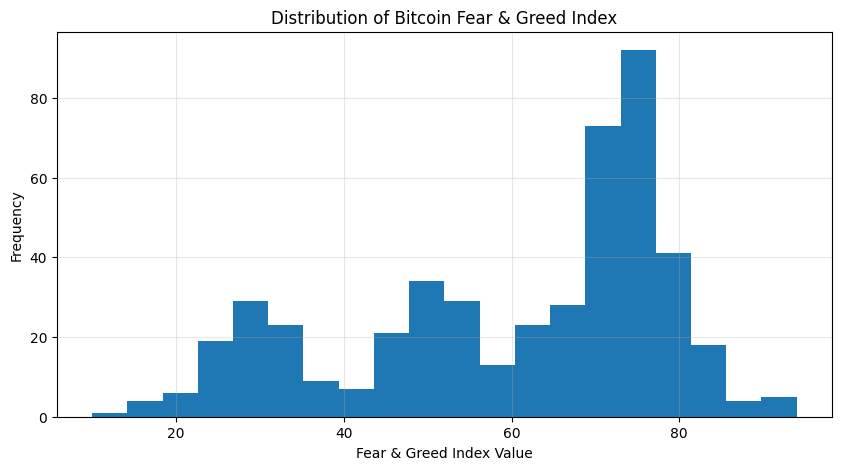

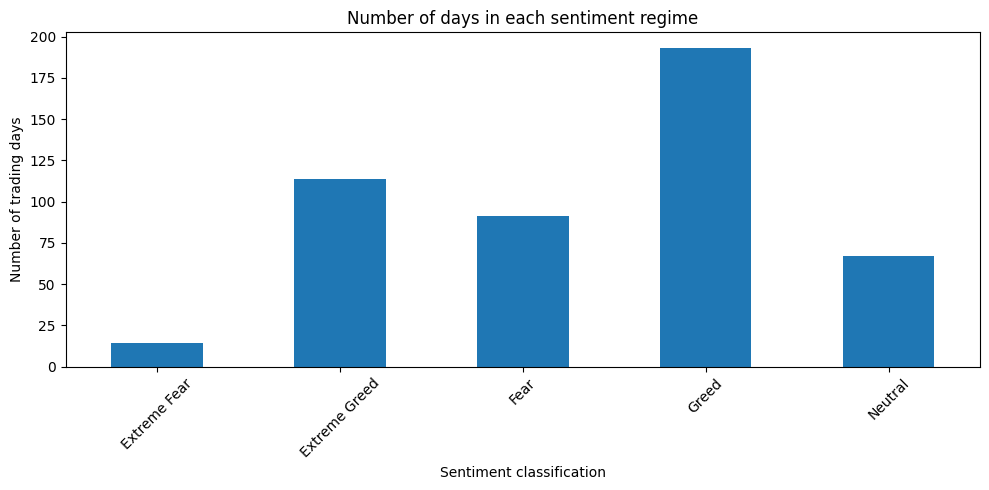

,day_count
classification,
Extreme Fear,14
Extreme Greed,114
Fear,91
Greed,193
Neutral,67


In [8]:
# Distribution of the numeric Fear & Greed Index
plt.figure()
plt.hist(merged['value'].dropna(), bins=20)
plt.xlabel('Fear & Greed Index Value')
plt.ylabel('Frequency')
plt.title('Distribution of Bitcoin Fear & Greed Index')
plt.grid(alpha=0.3)
plt.show()

# Count of each sentiment classification
class_counts = merged['classification'].value_counts().sort_index()
plt.figure()
class_counts.plot(kind='bar')
plt.xlabel('Sentiment classification')
plt.ylabel('Number of trading days')
plt.title('Number of days in each sentiment regime')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(class_counts.to_frame('day_count'))

*Chart 1st*
-The market was usually greedy.
-Fearful days were less common but important for analysis because trader performance often changes during fear periods.
-This helps you understand the emotional background of the market during the trades.

*Chart 2nd*
-Market was mostly Greedy or Extremely Greedy.
-Fear and Neutral days exist but are fewer.
-Extreme Fear days are very rare.
-This distribution helps understand how often the market is in each emotional state, which is useful for analyzing how trader performance changes across different sentiment regimes.

### 4.2 Trader performance over time

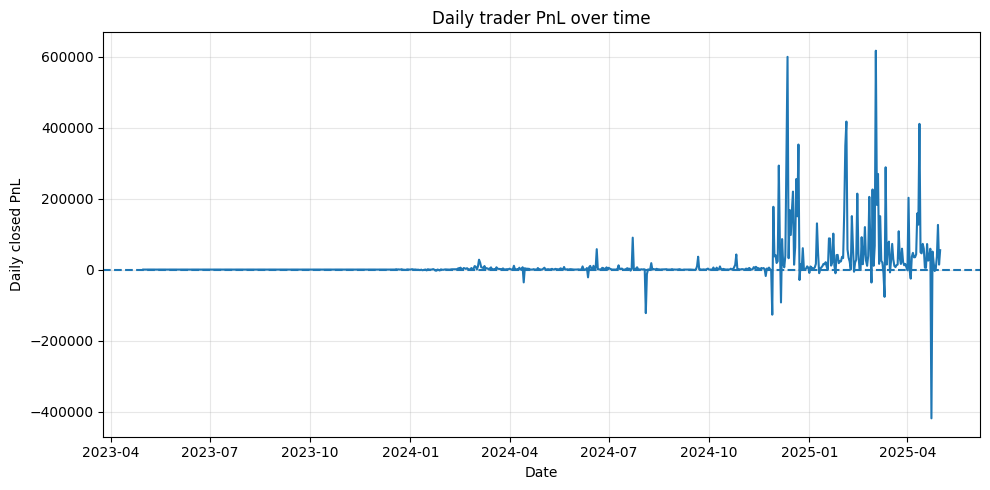

In [11]:
plt.figure()
plt.plot(merged['date'], merged['daily_closed_pnl'])
plt.axhline(0, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Daily closed PnL')
plt.title('Daily trader PnL over time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

2023 to mid-2024: Calm period, almost no profit/loss.

Late 2024 to 2025: Big swings, high profits and losses.

Trading became much more aggressive and volatile over time.

### 4.3 Average PnL by sentiment regime

Average daily PnL by sentiment:


,avg_daily_closed_pnl
classification,
Greed,"11,140.57"
Neutral,"19,297.32"
Extreme Greed,"23,817.29"
Fear,"36,891.82"
Extreme Fear,"52,793.59"


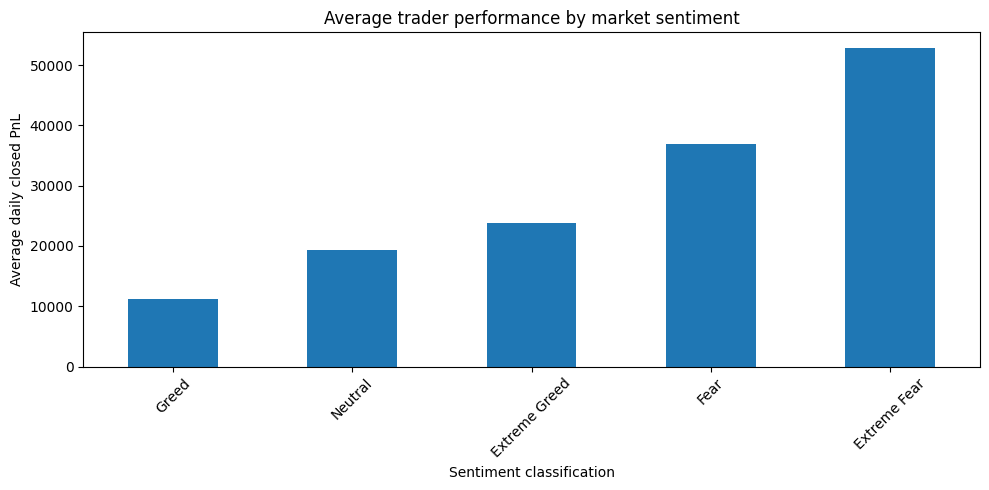

In [12]:
avg_pnl_by_sentiment = (
    merged
    .groupby('classification')['daily_closed_pnl']
    .mean()
    .sort_values()
)

print('Average daily PnL by sentiment:')
display(avg_pnl_by_sentiment.to_frame('avg_daily_closed_pnl'))

plt.figure()
avg_pnl_by_sentiment.plot(kind='bar')
plt.ylabel('Average daily closed PnL')
plt.xlabel('Sentiment classification')
plt.title('Average trader performance by market sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

“Trader performance increases as sentiment shifts from Greed to Extreme Fear, suggesting that the best trading opportunities occur during fearful market conditions.”

### 4.4 PnL distribution by sentiment

<Figure size 1000x500 with 0 Axes>

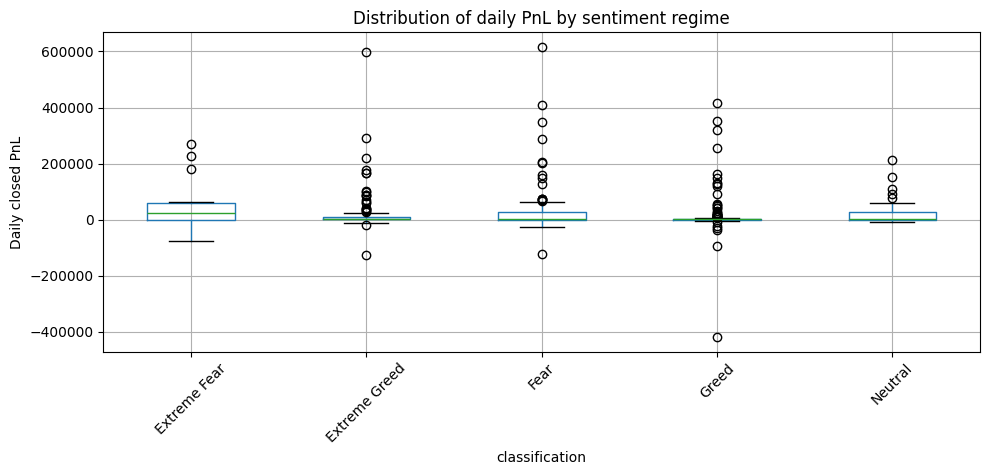

In [13]:
# Boxplot to show full PnL distribution by class
plt.figure()
merged.boxplot(column='daily_closed_pnl', by='classification')
plt.ylabel('Daily closed PnL')
plt.title('Distribution of daily PnL by sentiment regime')
plt.suptitle('')  # remove automatic title
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Traders earn the most during Fear and Extreme Fear days, while Greed days show lower performance and more losses. The boxplot clearly shows that fearful markets create the best profit opportunities.


### 4.5 Relationship between sentiment value and PnL

Correlation between Fear & Greed value and daily PnL: -0.0826


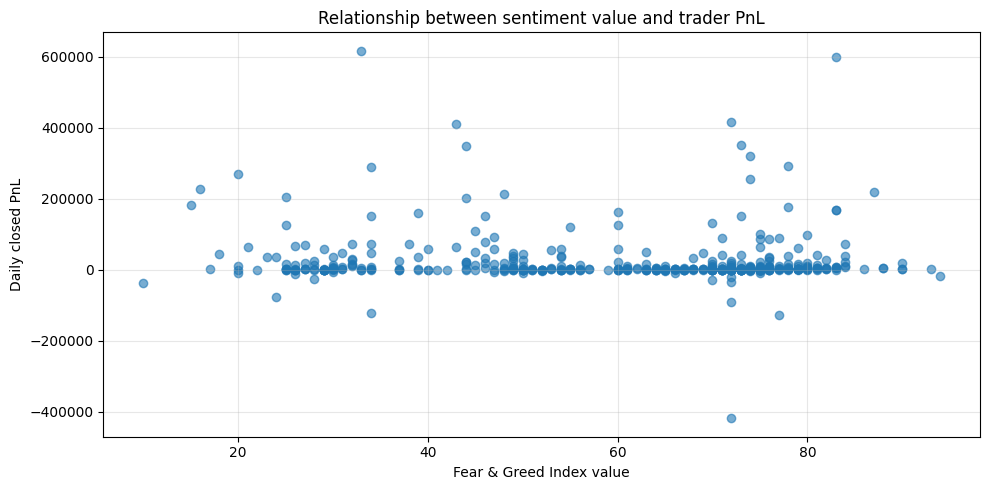

In [15]:
# Pearson correlation between numeric index and PnL
corr = merged['daily_closed_pnl'].corr(merged['value'])
print(f'Correlation between Fear & Greed value and daily PnL: {corr:.4f}')

# Scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(merged['value'], merged['daily_closed_pnl'], alpha=0.6)
plt.xlabel('Fear & Greed Index value')
plt.ylabel('Daily closed PnL')
plt.title('Relationship between sentiment value and trader PnL')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The Fear & Greed score does not strongly predict daily PnL, but big profits often occur on moderate-sentiment days (20–70). Extreme greed leads to mixed results with more volatility.


## 5. Key takeaways

 
1. **Performance by sentiment regime**  
   The table and bar chart of *average daily PnL by sentiment* show how trader performance changes between regimes such as *Extreme Fear*, *Fear*, *Neutral*, *Greed*, and *Extreme Greed*.

2. **Risk–return profile across regimes**  
   The boxplot highlights not only the average PnL but also the **volatility and downside risk** in each sentiment regime.

3. **Continuous relationship (index value vs PnL)**  
   The correlation and scatter plot indicate whether the numeric Fear & Greed Index is a strong predictor of PnL, or whether it should be used only as a **regime filter** instead of a precise signal.

4. **Account-level behaviour (optional section)**  
   By looking at PnL grouped by `Account` and `classification`, we can identify which traders perform best in fearful markets versus greedy markets. This can inform **allocation, copying strategies, or risk limits**.

---

### How this can be used in a real strategy

 1. Use market sentiment as a trading filter

Your data shows that traders make the highest profits during Fear and Extreme Fear days.
So, in a real strategy:

Trade more actively when sentiment = Fear / Extreme Fear

Reduce position size or avoid risky trades when sentiment = Greed / Extreme Greed


2. Build a simple rule-based strategy

You can create rules like:

If sentiment is Fear or Extreme Fear → allow trades

If sentiment is Greed → trade only with small size

If sentiment is Extreme Greed → avoid new long positions

Then you can backtest this strategy to see how much profit it would generate.
 